# Analyze Contributions of different methods to Annotation

This notebook analyzes relative contributions of different IEA methods to annotation

In [2]:
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from oaklib.datamodels.association import Association
from oaklib.parsers.gaf_association_parser import GafAssociationColumns
from oaklib.utilities.associations.association_differ import AssociationDiffer
from oaklib.utilities.subsets.slimmer_utils import filter_redundant
import pandas as pd

# Get a GO handle
go = get_adapter("sqlite:obo:go")

In [3]:
# Data Dictionary
GENE = GafAssociationColumns.local_id.value
TERM = GafAssociationColumns.ontology_class_ref.value

In [4]:
# Cache HTTP requests
import requests_cache
requests_cache.install_cache("output/requests_cache")

In [5]:
# Alias for GO command line queries

In [6]:
%alias go runoak -i sqlite:obo:go

## Routine to parse a GAF to a DataFrame

In [9]:
def gaf2df(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", comment="!", names=[c.value for c in GafAssociationColumns])
    return df.query(f"'|' not in qualifiers")

df = gaf2df("../../../../tests/input/mgi-truncated.gaf")         
df

,db,local_id,db_object_symbol,qualifiers,ontology_class_ref,supporting_references,evidence_type,with_or_from,aspect,db_object_name,db_object_synonyms,db_object_type,db_object_taxon,annotation_date,assigned_by,annotation_extensions,gene_product_form
0,MGI,MGI:1918911,0610005C13Rik,enables,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20200917,MGI,NaN,NaN
1,MGI,MGI:1918911,0610005C13Rik,is_active_in,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
2,MGI,MGI:1918911,0610005C13Rik,involved_in,GO:0008150,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,P,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
3,MGI,MGI:1923503,0610006L08Rik,enables,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN
4,MGI,MGI:1923503,0610006L08Rik,is_active_in,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN
5,MGI,MGI:1923503,0610006L08Rik,involved_in,GO:0008150,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,P,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN
6,MGI,MGI:1925547,0610008J02Rik,enables,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610008J02 gene,NaN,gene,taxon:10090,20210426,MGI,NaN,NaN
7,MGI,MGI:1925547,0610008J02Rik,is_active_in,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610008J02 gene,NaN,gene,taxon:10090,20210426,MGI,NaN,NaN
8,MGI,MGI:1925547,0610008J02Rik,involved_in,GO:0008150,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,P,RIKEN cDNA 0610008J02 gene,NaN,gene,taxon:10090,20210426,MGI,NaN,NaN
9,MGI,MGI:1913300,0610009B22Rik,involved_in,GO:0001501,MGI:MGI:4834177|GO_REF:0000096,ISO,UniProtKB:P0DI81,P,RIKEN cDNA 0610009B22 gene,NaN,protein,taxon:10090,20110927,MGI,NaN,NaN


In [14]:

COMMON = "common"
UNIQUE1 = "unique1"
UNIQUE2 = "unique2"

def old_compare_gene_dfs(gene, df1, df2, preds=None):
    terms1 = set(df1[TERM])
    terms2 = set(df2[TERM])
    closure1 = set(list(go.ancestors(list(terms1), preds)))
    closure2 = set(list(go.ancestors(list(terms2), preds)))
    nr_closure1 = set(filter_redundant(go, closure1, preds))
    nr_closure2 = set(filter_redundant(go, closure2, preds))
    unique1 = nr_closure1.difference(nr_closure2)
    unique2 = nr_closure2.difference(nr_closure1)
    return {GENE: gene, UNIQUE1: unique1, UNIQUE2: unique2}

def old_compare_gaf_dfs(df1, df2, preds=[IS_A, PART_OF]):
    genes1 = set(df1[GENE])
    genes2 = set(df2[GENE])
    objs = []
    for gene in genes1.union(genes2):
        subdf1 = df1.query(f"{GENE} == '{gene}'")
        subdf2 = df2.query(f"{GENE} == '{gene}'")
        for obj in compare_gene_dfs(gene, subdf1, subdf2, preds):
            objs.append(obj)
    return pd.DataFrame(objs)

compare_gaf_dfs(df1, df2, preds=[IS_A, PART_OF])

,0
0,local_id
1,unique1
2,unique2
3,local_id
4,unique1
5,unique2
6,local_id
7,unique1
8,unique2
9,local_id


## Function to analyze contribution

In [10]:
def df2assocs(df):
    # TODO: why not use GAF adapter?
    for _, row in df.iterrows():
        yield Association(subject=row[GENE], object=row[TERM])
        
def compare_gaf_dfs(df1, df2, preds=[IS_A, PART_OF]):
    """
    Perform an association diff between two GAF DataFrames
    """
    assocs1 = list(df2assocs(df1))
    assocs2 = list(df2assocs(df2))
    differ = AssociationDiffer(go)
    objs = []
    for ch in differ.calculate_change_objects(assocs1, assocs2, preds):
        objs.append(ch)
    return pd.DataFrame(objs).dropna(axis=1, how='all')

compare_gaf_dfs(df1, df2, preds=[IS_A, PART_OF])

NameError: name 'df1' is not defined

## Human GAF analysis

In [89]:
!mkdir -p input

In [22]:
!curl -L -s http://release.geneontology.org/2023-04-01/annotations/goa_human.gaf.gz | gzip -dc > input/goa_human.gaf

In [11]:
!head input/goa_human.gaf

!gaf-version: 2.2
!
!generated-by: GOC
!
!date-generated: 2023-04-02T12:17
!
!Header from source association file:
!=================================
!
!generated-by: GOC


In [12]:
df = gaf2df("input/goa_human.gaf")

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_46260/614969007.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep="\t", comment="!", names=[c.value for c in GafAssociationColumns])


In [13]:
df

,db,local_id,db_object_symbol,qualifiers,ontology_class_ref,supporting_references,evidence_type,with_or_from,aspect,db_object_name,db_object_synonyms,db_object_type,db_object_taxon,annotation_date,assigned_by,annotation_extensions,gene_product_form
0,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0003723,GO_REF:0000043,IEA,UniProtKB-KW:KW-0694,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20230306,UniProt,NaN,NaN
1,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0046872,GO_REF:0000043,IEA,UniProtKB-KW:KW-0479,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20230306,UniProt,NaN,NaN
2,UniProtKB,A0A024RBG1,NUDT4B,located_in,GO:0005829,GO_REF:0000052,IDA,NaN,C,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20161204,HPA,NaN,NaN
3,UniProtKB,A0A075B6H7,IGKV3-7,involved_in,GO:0002250,GO_REF:0000043,IEA,UniProtKB-KW:KW-1064,P,Probable non-functional immunoglobulin kappa v...,IGKV3-7,protein,taxon:9606,20230306,UniProt,NaN,NaN
4,UniProtKB,A0A075B6H7,IGKV3-7,located_in,GO:0005886,GO_REF:0000044,IEA,UniProtKB-SubCell:SL-0039,C,Probable non-functional immunoglobulin kappa v...,IGKV3-7,protein,taxon:9606,20230306,UniProt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630736,UniProtKB,P35580,MYH10,involved_in,GO:0031032,PMID:21873635,IBA,PANTHER:PTN002897265|UniProtKB:P35580|MGI:MGI:...,P,Myosin-10,MYH10,protein,taxon:9606,20220223,GO_Central,NaN,NaN
630737,UniProtKB,Q10472,GALNT1,involved_in,GO:0006493,PMID:21873635,IBA,PANTHER:PTN004287905|WB:WBGene00001630|UniProt...,P,Polypeptide N-acetylgalactosaminyltransferase 1,GALNT1,protein,taxon:9606,20230110,GO_Central,NaN,NaN
630738,UniProtKB,Q6NXT2,H3-5,is_active_in,GO:0005634,PMID:21873635,IBA,PANTHER:PTN008517671|dictyBase:DDB_G0271092|Un...,C,Histone H3.3C,H3-5|H3F3C,protein,taxon:9606,20230110,GO_Central,NaN,NaN
630739,UniProtKB,Q9NS87,KIF15,is_active_in,GO:0005874,PMID:21873635,IBA,PANTHER:PTN000648413|UniProtKB:C8V3Q8|UniProtK...,C,Kinesin-like protein KIF15,KIF15|KLP2|KNSL7,protein,taxon:9606,20230111,GO_Central,NaN,NaN


In [14]:
iea = df.query("evidence_type == 'IEA'")
iea.groupby(['supporting_references']).count()

,db,local_id,db_object_symbol,qualifiers,ontology_class_ref,evidence_type,with_or_from,aspect,db_object_name,db_object_synonyms,db_object_type,db_object_taxon,annotation_date,assigned_by,annotation_extensions,gene_product_form
supporting_references,,,,,,,,,,,,,,,,
GO_REF:0000002,6331,6331,6331,6331,6331,6331,6331,6331,6331,6321,6331,6331,6331,6331,0,0
GO_REF:0000003,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052,0,0
GO_REF:0000041,738,738,738,738,738,738,738,738,738,738,738,738,738,738,0,0
GO_REF:0000043,13433,13433,13433,13433,13433,13433,13433,13433,13433,13418,13433,13433,13433,13433,0,0
GO_REF:0000044,8086,8086,8086,8086,8086,8086,8086,8086,8086,8073,8086,8086,8086,8086,0,0
GO_REF:0000104,199,199,199,199,199,199,199,199,199,199,199,199,199,199,0,0
GO_REF:0000107,39108,39108,39108,39108,39108,39108,39108,39108,39108,39108,39108,39108,39108,39108,0,0
GO_REF:0000108,3680,3680,3680,3680,3680,3680,3680,3680,3680,3678,3680,3680,3680,3680,0,0
GO_REF:0000116,1147,1147,1147,1147,1147,1147,1147,1147,1147,1147,1147,1147,1147,1147,0,0


## Fetch all GOREFs

In [15]:
gorefs = set(iea['supporting_references'])
gorefs

{'GO_REF:0000002',
 'GO_REF:0000003',
 'GO_REF:0000041',
 'GO_REF:0000043',
 'GO_REF:0000044',
 'GO_REF:0000104',
 'GO_REF:0000107',
 'GO_REF:0000108',
 'GO_REF:0000116',
 'GO_REF:0000117'}

In [16]:
def add_labels(df):
    """
    Annotate Diff DataFrame with labels for the objects that are "lost"
    """
    df["old_object_label"] = df.apply(lambda row: go.label(row["old_object"]), axis=1)

In [17]:
def analyze_iea(df, ref):
    """
    Simulate deleting the IEAs with the stated reference.
    """
    df_minus = df.query(f'supporting_references != "{ref}"')
    return compare_gaf_dfs(df, df_minus)

## RHEA

In [43]:
rhea = analyze_iea(df, "GO_REF:0000116")

In [66]:
add_labels(rhea)
rhea

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,old_object_label
0,[],P22612,GO:0106310,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,protein serine kinase activity
1,[],Q9Y3S1,GO:0106310,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,protein serine kinase activity
2,[],Q9NUU7,GO:0016887,False,True,"[rdfs:subClassOf, BFO:0000050]",-6,ATP hydrolysis activity
3,[],Q16584,GO:0106310,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,protein serine kinase activity
4,[],P17516,GO:0047045,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,testosterone 17-beta-dehydrogenase (NADP+) act...
...,...,...,...,...,...,...,...,...
720,[],Q5VST9,GO:0106310,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,protein serine kinase activity
721,[],O43293,GO:0106310,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,protein serine kinase activity
722,[],Q9H2U1,GO:0016887,False,True,"[rdfs:subClassOf, BFO:0000050]",-6,ATP hydrolysis activity
723,[],Q6DHV7,GO:0062154,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,N6-methyl-AMP deaminase activity


In [70]:
lbl = ['old_object', 'old_object_label']
rhea.groupby(lbl).mean(numeric_only=True)

,,old_object_obsolete,is_deletion,closure_delta
old_object,old_object_label,,,
GO:0002083,4-hydroxybenzoate decaprenyltransferase activity,0.0,1.0,-2.0
GO:0003924,GTPase activity,0.0,1.0,-5.0
GO:0003954,NADH dehydrogenase activity,0.0,1.0,-1.0
GO:0004052,arachidonate 12(S)-lipoxygenase activity,0.0,1.0,-1.0
GO:0004115,"3',5'-cyclic-AMP phosphodiesterase activity",0.0,1.0,-2.0
...,...,...,...,...
GO:0140947,histone H3K9me2 methyltransferase activity,0.0,1.0,-1.0
GO:0140948,histone H3K9 monomethyltransferase activity,0.0,1.0,-1.0
GO:1901480,oleate transmembrane transporter activity,0.0,1.0,-1.0


In [73]:
pd.set_option('display.max_rows', 1000)
rhea.groupby(lbl).min(numeric_only=True).sort_values("closure_delta")

,,old_object_obsolete,is_deletion,closure_delta
old_object,old_object_label,,,
GO:0016279,protein-lysine N-methyltransferase activity,False,True,-10
GO:0140933,5'-(N(7)-methylguanosine 5'-triphospho)-[mRNA] hydrolase activity,False,True,-9
GO:0016887,ATP hydrolysis activity,False,True,-7
GO:0003924,GTPase activity,False,True,-7
GO:0052665,tRNA (uracil-2'-O-)-methyltransferase activity,False,True,-4
GO:0036134,12-hydroxyheptadecatrienoic acid synthase activity,False,True,-4
GO:0004713,protein tyrosine kinase activity,False,True,-4
GO:0090555,phosphatidylethanolamine flippase activity,False,True,-4
GO:0097023,fructose 6-phosphate aldolase activity,False,True,-4


In [79]:
rhea.groupby("subject").count().query("publications > 3")

,publications,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,old_object_label
subject,,,,,,,
P22413,4,4,4,4,4,4,4


In [80]:
rhea.query("subject == 'P22413'")

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,old_object_label
483,[],P22413,GO:0036221,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,UTP diphosphatase activity
484,[],P22413,GO:0004115,False,True,"[rdfs:subClassOf, BFO:0000050]",-3,"3',5'-cyclic-AMP phosphodiesterase activity"
485,[],P22413,GO:0036219,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GTP diphosphatase activity
486,[],P22413,GO:0047693,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,ATP diphosphatase activity


In [81]:
rhea[["closure_delta"]].sum()

closure_delta   -1341
dtype: int64

## ARBA

In [74]:
arba = analyze_iea(df, "GO_REF:0000117")

In [84]:
add_labels(arba)

In [85]:
pd.set_option('display.max_rows', 10)
arba

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,old_object_label
0,[],Q96JM4,GO:0009966,None,True,[],-10,regulation of signal transduction
1,[],Q96MZ0,GO:0005737,None,True,[],-15,cytoplasm
2,[],P37275,GO:0044271,False,True,"[rdfs:subClassOf, BFO:0000050]",0,cellular nitrogen compound biosynthetic process
3,[],Q8TC17,GO:0005737,False,True,"[rdfs:subClassOf, BFO:0000050]",-15,cytoplasm
4,[],Q9Y5H1,GO:0007399,False,True,"[rdfs:subClassOf, BFO:0000050]",-6,nervous system development
...,...,...,...,...,...,...,...,...
207,[],P32745,GO:0007187,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,"G protein-coupled receptor signaling pathway, ..."
208,[],P32745,GO:0008285,False,True,"[rdfs:subClassOf, BFO:0000050]",-4,negative regulation of cell population prolife...
209,[],P29144,GO:0006508,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,proteolysis
210,[],Q9Y5G2,GO:0007399,False,True,"[rdfs:subClassOf, BFO:0000050]",-6,nervous system development


In [82]:
arba[["closure_delta"]].sum()

closure_delta   -1252
dtype: int64

In [86]:
pd.set_option('display.max_rows', 1000)
arba.groupby(lbl).min(numeric_only=True).sort_values("closure_delta")

,,is_deletion,closure_delta
old_object,old_object_label,,
GO:0045892,negative regulation of DNA-templated transcription,True,-31
GO:0022625,cytosolic large ribosomal subunit,True,-28
GO:0005783,endoplasmic reticulum,True,-21
GO:0005634,nucleus,True,-19
GO:0043162,ubiquitin-dependent protein catabolic process via the multivesicular body sorting pathway,True,-18
GO:0007080,mitotic metaphase plate congression,True,-18
GO:0006470,protein dephosphorylation,True,-16
GO:1901673,regulation of mitotic spindle assembly,True,-16
GO:0005737,cytoplasm,True,-15


## All IEAs

In [87]:
# this takes some time....
dfs_by_ref = {}
for goref in gorefs:
    print(goref)
    dfs_by_ref[goref] = analyze_iea(df, goref)

In [92]:
for k, df in dfs_by_ref.items():
    df["method"] = k

In [93]:
dfs_by_ref["GO_REF:0000041"]

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method
0,[],Q53EU6,GO:0016024,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041
1,[],Q5VZY2,GO:0006644,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041
2,[],P10632,GO:0042572,False,True,"[rdfs:subClassOf, BFO:0000050]",-4,GO_REF:0000041
3,[],Q9NXB9,GO:0006636,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000041
4,[],Q969V5,GO:0016925,False,True,"[rdfs:subClassOf, BFO:0000050]",-3,GO_REF:0000041
5,[],Q9P2W7,GO:0006486,False,True,"[rdfs:subClassOf, BFO:0000050]",-5,GO_REF:0000041
6,[],A6NK59,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-12,GO_REF:0000041
7,[],Q9H1B5,GO:0030206,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041
8,[],Q693B1,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-12,GO_REF:0000041
9,[],O60927,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-5,GO_REF:0000041


In [98]:
mega_df = pd.DataFrame()
for df in dfs_by_ref.values():
    mega_df.append(df)
mega_df

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_40496/2637639069.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mega_df.append(df)


""


In [99]:
mega_df = pd.concat(dfs_by_ref.values())
mega_df

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method
0,[],Q5VVH2,GO:0003755,None,True,[],-8,GO_REF:0000003
1,[],Q53EU6,GO:0102420,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000003
2,[],O95237,GO:0102279,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000003
3,[],P22612,GO:0004679,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000003
4,[],P17516,GO:0035410,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000003
...,...,...,...,...,...,...,...,...
13324,[],Q8N3I7,GO:0050896,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000043
13325,[],O15067,GO:0005524,False,True,"[rdfs:subClassOf, BFO:0000050]",-16,GO_REF:0000043
13326,[],O15067,GO:0046872,False,True,"[rdfs:subClassOf, BFO:0000050]",-4,GO_REF:0000043
13327,[],A1L3X4,GO:0046872,False,True,"[rdfs:subClassOf, BFO:0000050]",-3,GO_REF:0000043


In [100]:
mega_df.groupby("method").mean(numeric_only=True)

,is_deletion,closure_delta
method,,
GO_REF:0000002,1.0,-6.256293
GO_REF:0000003,1.0,-2.435816
GO_REF:0000041,1.0,-9.901235
GO_REF:0000043,1.0,-5.570560
GO_REF:0000044,1.0,-6.311431
GO_REF:0000104,1.0,-6.020101
GO_REF:0000107,1.0,-7.604500
GO_REF:0000108,1.0,-0.619598
GO_REF:0000116,1.0,-1.849655


## Unipathway

In [104]:
unipathway = dfs_by_ref["GO_REF:0000041"]
add_labels(unipathway)
unipathway

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method,old_object_label
0,[],Q53EU6,GO:0016024,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041,CDP-diacylglycerol biosynthetic process
1,[],Q5VZY2,GO:0006644,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041,phospholipid metabolic process
2,[],P10632,GO:0042572,False,True,"[rdfs:subClassOf, BFO:0000050]",-4,GO_REF:0000041,retinol metabolic process
3,[],Q9NXB9,GO:0006636,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000041,unsaturated fatty acid biosynthetic process
4,[],Q969V5,GO:0016925,False,True,"[rdfs:subClassOf, BFO:0000050]",-3,GO_REF:0000041,protein sumoylation
5,[],Q9P2W7,GO:0006486,False,True,"[rdfs:subClassOf, BFO:0000050]",-5,GO_REF:0000041,protein glycosylation
6,[],A6NK59,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-12,GO_REF:0000041,protein ubiquitination
7,[],Q9H1B5,GO:0030206,False,True,"[rdfs:subClassOf, BFO:0000050]",-2,GO_REF:0000041,chondroitin sulfate biosynthetic process
8,[],Q693B1,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-12,GO_REF:0000041,protein ubiquitination
9,[],O60927,GO:0016567,False,True,"[rdfs:subClassOf, BFO:0000050]",-5,GO_REF:0000041,protein ubiquitination


In [105]:
pd.set_option('display.max_rows', 1000)
unipathway.groupby(lbl).min(numeric_only=True).sort_values("closure_delta")

,,old_object_obsolete,is_deletion,closure_delta
old_object,old_object_label,,,
GO:0046069,cGMP catabolic process,False,True,-46
GO:0006506,GPI anchor biosynthetic process,False,True,-46
GO:0006198,cAMP catabolic process,False,True,-46
GO:0033512,L-lysine catabolic process to acetyl-CoA via saccharopine,False,True,-40
GO:0044206,UMP salvage,False,True,-35
GO:0017183,peptidyl-diphthamide biosynthetic process from peptidyl-histidine,False,True,-33
GO:0006635,fatty acid beta-oxidation,False,True,-28
GO:0042853,L-alanine catabolic process,False,True,-26
GO:0019557,histidine catabolic process to glutamate and formate,False,True,-25


In [108]:
unipathway.query("old_object == 'GO:0042853'")

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method,old_object_label
18,[],Q8TD30,GO:0042853,False,True,"[rdfs:subClassOf, BFO:0000050]",-12,GO_REF:0000041,L-alanine catabolic process
226,[],P24298,GO:0042853,False,True,"[rdfs:subClassOf, BFO:0000050]",-26,GO_REF:0000041,L-alanine catabolic process


## Difference across species

In [134]:
human = mega_df

In [129]:
def analyze_gaf(gaf_path):
    species_df = gaf2df(gaf_path)
    print(len(species_df))
    by_ref = {}
    dfs = []
    for goref in gorefs:
        print(goref)
        df = analyze_iea(species_df, goref)
        print(len(df))
        df['method'] = goref
        dfs.append(df)
    all_df = pd.concat(dfs)
    return all_df

In [124]:
sgd_gaf = gaf2df("input/sgd.gaf")

In [125]:
sgd_gaf

,db,local_id,db_object_symbol,qualifiers,ontology_class_ref,supporting_references,evidence_type,with_or_from,aspect,db_object_name,db_object_synonyms,db_object_type,db_object_taxon,annotation_date,assigned_by,annotation_extensions,gene_product_form
0,SGD,S000000735,GCN4,involved_in,GO:1990139,PMID:31211995,IMP,NaN,P,bZIP transcriptional activator of amino acid b...,YEL009C|AAS3|ARG9|AAS101|amino acid starvation...,protein,taxon:559292,20200206,SGD,NaN,UniProtKB:P03069
1,SGD,S000003026,RAD6,contributes_to,GO:0017116,PMID:9287349,IDA,NaN,F,Ubiquitin-conjugating enzyme (E2),YGL058W|PSO8|UBC2|E2 ubiquitin-conjugating pro...,protein,taxon:559292,20131012,SGD,part_of(GO:0097505),UniProtKB:P06104
2,SGD,S000001503,SPT23,enables,GO:0003674,GO_REF:0000015,ND,NaN,F,ER membrane protein involved in regulation of ...,YKL020C,protein,taxon:559292,20181102,SGD,NaN,UniProtKB:P35210
3,SGD,S000028746,FMP49,located_in,GO:0005739,PMID:14576278,HDA,NaN,C,Mitochondrial protein of unknown function,YER038W-A,protein,taxon:559292,20040923,SGD,NaN,UniProtKB:A0A023PZB3
4,SGD,S000005730,DED1,enables,GO:0003724,PMID:10364207,IDA,NaN,F,ATP-dependent DEAD-box RNA helicase with stran...,YOR204W|SPP81|DEAD-box ATP-dependent RNA helic...,protein,taxon:559292,20090529,SGD,NaN,UniProtKB:P06634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121507,SGD,S000000871,ARG56,enables,GO:0003942,PMID:21873635,IBA,PANTHER:PTN001155520|PomBase:SPAC4G9.09c|SGD:S...,F,bifunctional acetylglutamate kinase/N-acetyl-g...,ARG56|YER069W,protein,taxon:559292,20170228,GO_Central,NaN,NaN
121508,SGD,S000003824,RPA12,contributes_to,GO:0001054,PMID:21873635,IBA,PANTHER:PTN000133053|SGD:S000003824,F,DNA-directed RNA polymerase I core subunit RPA12,RPA12|RRN4|YJR063W,protein,taxon:559292,20170228,GO_Central,NaN,NaN
121509,SGD,S000006377,VPS4,involved_in,GO:0016197,PMID:21873635,IBA,PANTHER:PTN000553912|UniProtKB:Q9UN37|PomBase:...,P,AAA family ATPase VPS4,VPS4|VPL4|VPT10|DID6|CSC1|END13|GRD13|YPR173C,protein,taxon:559292,20221008,GO_Central,NaN,NaN
121510,SGD,S000001412,MCM10,enables,GO:0003688,PMID:21873635,IBA,PANTHER:PTN000335708|SGD:S000001412,F,NaN,MCM10|DNA43|YIL150C,protein,taxon:559292,20170228,GO_Central,NaN,NaN


In [126]:
sgd_foo = analyze_iea(sgd_gaf, "GO_REF:0000002")

In [128]:
sgd_foo["method"] = "GO_REF:0000002"
sgd_foo

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method
0,[],S000005069,GO:0022857,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
1,[],S000005069,GO:0055085,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
2,[],S000006233,GO:0016192,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
3,[],S000006233,GO:0030117,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
4,[],S000006233,GO:0006886,False,True,"[rdfs:subClassOf, BFO:0000050]",-1,GO_REF:0000002
...,...,...,...,...,...,...,...,...
3743,[],S000005730,GO:0003676,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
3744,[],S000001208,GO:0000398,False,True,"[rdfs:subClassOf, BFO:0000050]",0,GO_REF:0000002
3745,[],S000001208,GO:0008237,False,True,"[rdfs:subClassOf, BFO:0000050]",-4,GO_REF:0000002
3746,[],S000001208,GO:0008233,False,True,"[rdfs:subClassOf, BFO:0000050]",-3,GO_REF:0000002


In [130]:
sgd = analyze_gaf("input/sgd.gaf")

121512
GO_REF:0000003
362
GO_REF:0000044
1040
GO_REF:0000002
3748
GO_REF:0000116
0
GO_REF:0000117
1587
GO_REF:0000107
0
GO_REF:0000108
1028
GO_REF:0000041
186
GO_REF:0000104
127
GO_REF:0000043
11559


In [131]:
type(sgd)

pandas.core.frame.DataFrame

In [132]:
sgd

,publications,subject,old_object,old_object_obsolete,is_deletion,closure_predicates,closure_delta,method
0,[],S000002424,GO:0052724,False,True,"[rdfs:subClassOf, BFO:0000050]",-1.0,GO_REF:0000003
1,[],S000002424,GO:0000832,False,True,"[rdfs:subClassOf, BFO:0000050]",-1.0,GO_REF:0000003
2,[],S000002424,GO:0052723,False,True,"[rdfs:subClassOf, BFO:0000050]",-1.0,GO_REF:0000003
3,[],S000005313,GO:0052917,False,True,"[rdfs:subClassOf, BFO:0000050]",-1.0,GO_REF:0000003
4,[],S000002650,GO:0043864,False,True,"[rdfs:subClassOf, BFO:0000050]",-3.0,GO_REF:0000003
...,...,...,...,...,...,...,...,...
11554,[],S000005749,GO:0006897,False,True,"[rdfs:subClassOf, BFO:0000050]",-5.0,GO_REF:0000043
11555,[],S000005749,GO:0015031,False,True,"[rdfs:subClassOf, BFO:0000050]",-12.0,GO_REF:0000043
11556,[],S000001208,GO:0006397,False,True,"[rdfs:subClassOf, BFO:0000050]",0.0,GO_REF:0000043
11557,[],S000001208,GO:0008380,False,True,"[rdfs:subClassOf, BFO:0000050]",0.0,GO_REF:0000043


In [133]:
sgd.groupby("method").mean(numeric_only=True)

,closure_delta
method,
GO_REF:0000002,-2.113661
GO_REF:0000003,-1.919890
GO_REF:0000041,-5.155914
GO_REF:0000043,-1.074228
GO_REF:0000044,-2.593269
GO_REF:0000104,-3.551181
GO_REF:0000108,-0.389105
GO_REF:0000117,-0.192817


In [135]:
human.groupby("method").mean(numeric_only=True)

,is_deletion,closure_delta
method,,
GO_REF:0000002,1.0,-6.256293
GO_REF:0000003,1.0,-2.435816
GO_REF:0000041,1.0,-9.901235
GO_REF:0000043,1.0,-5.570560
GO_REF:0000044,1.0,-6.311431
GO_REF:0000104,1.0,-6.020101
GO_REF:0000107,1.0,-7.604500
GO_REF:0000108,1.0,-0.619598
GO_REF:0000116,1.0,-1.849655


In [136]:
human["species"] = "human"
sgd["species"] = "yeast"

In [138]:
all_df = pd.concat([human, sgd])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_40496/2618427164.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_df = pd.concat([human, sgd])


In [140]:
smry = all_df.groupby(["species", "method"]).mean(numeric_only=True)
smry

closure_delta
species method                       
human   GO_REF:0000002      -6.256293
        GO_REF:0000003      -2.435816
        GO_REF:0000041      -9.901235
        GO_REF:0000043      -5.570560
        GO_REF:0000044      -6.311431
        GO_REF:0000104      -6.020101
        GO_REF:0000107      -7.604500
        GO_REF:0000108      -0.619598
        GO_REF:0000116      -1.849655
        GO_REF:0000117      -5.905660
yeast   GO_REF:0000002      -2.113661
        GO_REF:0000003      -1.919890
        GO_REF:0000041      -5.155914
        GO_REF:0000043      -1.074228
        GO_REF:0000044      -2.593269
        GO_REF:0000104      -3.551181
        GO_REF:0000108      -0.389105
        GO_REF:0000117      -0.192817

In [143]:
smry.

AttributeError: 'DataFrame' object has no attribute 'names'

In [144]:
pombase = analyze_gaf("input/pombase.gaf")

54542
GO_REF:0000003
76
GO_REF:0000044
52
GO_REF:0000002
968
GO_REF:0000116
165
GO_REF:0000117
57
GO_REF:0000107
0
GO_REF:0000108
0
GO_REF:0000041
64
GO_REF:0000104
124
GO_REF:0000043
518


In [145]:
pombase.groupby("method").mean(numeric_only=True)

,closure_delta
method,
GO_REF:0000002,-5.535124
GO_REF:0000003,-1.815789
GO_REF:0000041,-10.796875
GO_REF:0000043,-10.403475
GO_REF:0000044,-4.615385
GO_REF:0000104,-5.669355
GO_REF:0000116,-3.793939
GO_REF:0000117,-6.228070


In [153]:
pombase["species"] = "pombe"
all_df = pd.concat([human, sgd, pombase])

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_40496/747263277.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  all_df = pd.concat([human, sgd, pombase])


In [154]:
all_df.groupby(["species", "method"]).mean(numeric_only=True)

closure_delta
species method                       
human   GO_REF:0000002      -6.256293
        GO_REF:0000003      -2.435816
        GO_REF:0000041      -9.901235
        GO_REF:0000043      -5.570560
        GO_REF:0000044      -6.311431
        GO_REF:0000104      -6.020101
        GO_REF:0000107      -7.604500
        GO_REF:0000108      -0.619598
        GO_REF:0000116      -1.849655
        GO_REF:0000117      -5.905660
pombe   GO_REF:0000002      -5.535124
        GO_REF:0000003      -1.815789
        GO_REF:0000041     -10.796875
        GO_REF:0000043     -10.403475
        GO_REF:0000044      -4.615385
        GO_REF:0000104      -5.669355
        GO_REF:0000116      -3.793939
        GO_REF:0000117      -6.228070
yeast   GO_REF:0000002      -2.113661
        GO_REF:0000003      -1.919890
        GO_REF:0000041      -5.155914
        GO_REF:0000043      -1.074228
        GO_REF:0000044      -2.593269
        GO_REF:0000104      -3.551181
        GO_REF:0000108      -0.389105
        GO_REF:0000117      -0.192817

In [169]:
all_df.groupby(["species", "method"]).sum(numeric_only=True)

closure_delta
species method                       
human   GO_REF:0000002       -39521.0
        GO_REF:0000003        -1537.0
        GO_REF:0000041        -3208.0
        GO_REF:0000043       -74250.0
        GO_REF:0000044       -50908.0
        GO_REF:0000104        -1198.0
        GO_REF:0000107      -294720.0
        GO_REF:0000108        -2036.0
        GO_REF:0000116        -1341.0
        GO_REF:0000117        -1252.0
pombe   GO_REF:0000002        -5358.0
        GO_REF:0000003         -138.0
        GO_REF:0000041         -691.0
        GO_REF:0000043        -5389.0
        GO_REF:0000044         -240.0
        GO_REF:0000104         -703.0
        GO_REF:0000116         -626.0
        GO_REF:0000117         -355.0
yeast   GO_REF:0000002        -7922.0
        GO_REF:0000003         -695.0
        GO_REF:0000041         -959.0
        GO_REF:0000043       -12417.0
        GO_REF:0000044        -2697.0
        GO_REF:0000104         -451.0
        GO_REF:0000108         -400.0
        GO_REF:0000117         -306.0

In [167]:
smry = all_df.groupby(["species", "method"]).sum(numeric_only=True) / all_df.groupby(["species"]).sum(numeric_only=True)
smry

closure_delta
species method                       
human   GO_REF:0000002       0.084092
        GO_REF:0000003       0.003270
        GO_REF:0000041       0.006826
        GO_REF:0000043       0.157988
        GO_REF:0000044       0.108322
        GO_REF:0000104       0.002549
        GO_REF:0000107       0.627103
        GO_REF:0000108       0.004332
        GO_REF:0000116       0.002853
        GO_REF:0000117       0.002664
pombe   GO_REF:0000002       0.396889
        GO_REF:0000003       0.010222
        GO_REF:0000041       0.051185
        GO_REF:0000043       0.399185
        GO_REF:0000044       0.017778
        GO_REF:0000104       0.052074
        GO_REF:0000116       0.046370
        GO_REF:0000117       0.026296
yeast   GO_REF:0000002       0.306496
        GO_REF:0000003       0.026889
        GO_REF:0000041       0.037103
        GO_REF:0000043       0.480404
        GO_REF:0000044       0.104345
        GO_REF:0000104       0.017449
        GO_REF:0000108       0.015476
        GO_REF:0000117       0.011839

<Axes: xlabel='species', ylabel='method'>

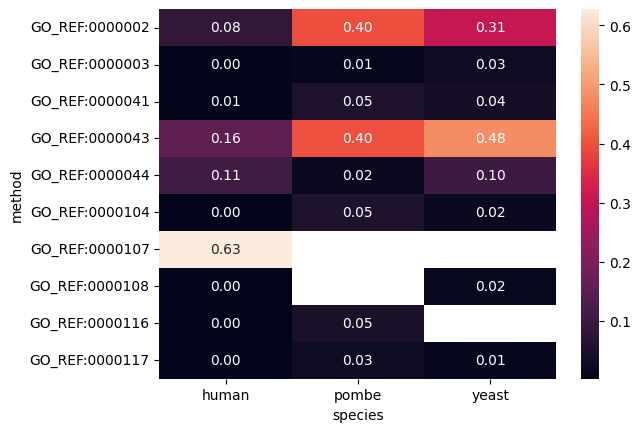

In [168]:
import seaborn

pivot = smry.reset_index().pivot(index="method", columns="species", values="closure_delta")
seaborn.heatmap(pivot, annot=True, fmt=".2f")

In [159]:
c.META.foo

AttributeError: 'dict' object has no attribute 'foo'